In [1]:
import os
import requests
import tarfile

def download_cifar10(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024
    with open(save_path, 'wb') as f:
        for data in response.iter_content(chunk_size=chunk_size):
            f.write(data)
            downloaded_size = os.path.getsize(save_path)
            progress = 100 * downloaded_size / total_size
            print('\rDownloading: {:.2f}%'.format(progress), end='', flush=True)
    print("\nDownload completed!")

# Download CIFAR-10 dataset
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
save_path = "./cifar-10-python.tar.gz"
download_cifar10(cifar10_url, save_path)

Downloading: 100.00%
Download completed!


In [1]:
import tarfile

def extract_cifar10(archive_path, extract_dir):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_dir)
    print("Extraction completed!")

archive_path = "cifar-10-python.tar.gz"
extract_dir = "cifar-10-python"
extract_cifar10(archive_path, extract_dir)


Extraction completed!


In [43]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pickle
def load_cifar10(data_dir):
    images = []
    labels = []
    try:
        for file in os.listdir(data_dir):
            if file.startswith('data_batch') or file.startswith('test_batch'):
                with open(os.path.join(data_dir, file), 'rb') as fo:
                    cifar_data = pickle.load(fo, encoding='bytes')
                    for i, image_data in enumerate(cifar_data[b'data']):
                        # CIFAR-10 images are in CHW format (channels, height, width)
                        # Reshape the image to HWC format (height, width, channels)
                        image = np.transpose(np.reshape(image_data, (3, 32, 32)), (1, 2, 0))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        label = cifar_data[b'labels'][i]
                        images.append(image)
                        labels.append(label)
    except Exception as e:
        print("Error loading CIFAR-10 dataset:", e)
    return np.array(images), np.array(labels)


# Function to preprocess images
def preprocess_images(images):
    # Resize images to a fixed size (e.g., 32x32)
    resized_images = [cv2.resize(image, (64, 64)) for image in images]
    processed_images = np.array(resized_images, dtype=np.float32) / 255.0
    return processed_images

data_dir = 'cifar-10-python/cifar-10-batches-py'
images, labels = load_cifar10(data_dir)

processed_images = preprocess_images(images)

X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, train_size=0.8, test_size=0.2, random_state=42)

n_classes = len(np.unique(y_train))

n_classes = len(np.unique(y_train))

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Image shape:", X_train.shape)
print("Number of classes:", n_classes)

processed_images
labels

Number of training samples: 48000
Number of test samples: 12000
Image shape: (48000, 64, 64)
Number of classes: 10


array([6, 9, 9, ..., 5, 1, 7])

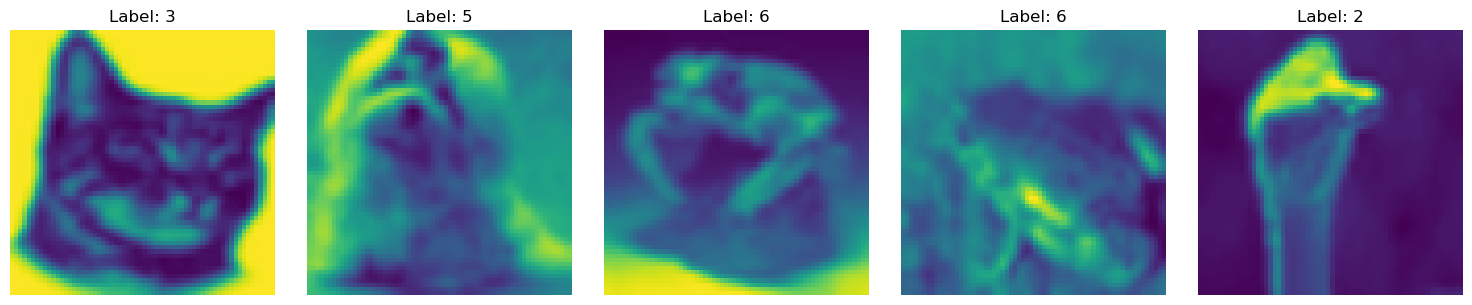

In [28]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title("Label: {}".format(labels[i]))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X_train[:5], y_train[:5])


In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

lda = LinearDiscriminantAnalysis(n_components=n_classes-1)
X_train_lda = lda.fit_transform(X_train_flat, y_train)
X_test_lda = lda.transform(X_test_flat)

# print("Shape of PCA-transformed training data:", X_train_pca.shape)
# print("Shape of LDA-transformed training data:", X_train_lda.shape)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_pca, y_train)

y_pred_pca = knn.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy on PCA-transformed test data:", accuracy_pca)


knn.fit(X_train_lda, y_train)

y_pred_lda = knn.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy on LDA-transformed test data:", accuracy_lda)


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_flat, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



In [42]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

model = SimpleClassifier(num_inputs=4096, num_hidden=1000, num_outputs=10)
model.to(device)


train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

loss_module = nn.BCEWithLogitsLoss()

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.26)

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
#             data_labels = data_labels.to(device)
            data_labels = data_labels.to(device).float().requires_grad_()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            max_values, max_indices = torch.max(preds, dim=1) 
            max_indices = max_indices.to(torch.float32)

            ## Step 3: Calculate the loss
            loss = loss_module(max_indices, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
            

train_model(model, optimizer, train_data_loader, loss_module)

test_dataset = data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device).float().requires_grad_()
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            max_values, max_indices = torch.max(preds, dim=1) 
            max_indices = max_indices.to(torch.float32)
            pred_labels = (max_indices >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    

eval_model(model, test_data_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of the model: 9.90%
